# Flip flops

Flipflops are inferred as soon as a clock signal comes into play. This is a standard scenario in an FPGA and referred to as *synchronous Design*, as signals inside the logic box you are describing are asserted synchronously with the clock.

We remember the most important generic property of a Flipflop: It holds its value until the next clock edge arrives. It's therefore also implied by the term 'register'. We are modifying our most simple XOR example by using a register instead of combinatorial logic:

In [1]:
from myhdl import *

@block
def sync_operation(clk, a, b, q):
    @always(clk.posedge)
    def worker():
        q.next = a ^ b

    return instances()

Now we create digital logic from the above:

CREATE Module: 'test'
Adding module with name: sync_operation_1_8_8_8
CONVERT_RTL tree >>>>>> 'TEST_WORKER' 
DONE instancing submodules
Generating RTL image...
Display...


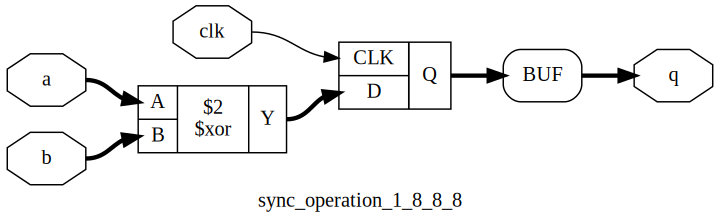

In [2]:
from ys_aux import to_svg
from myhdl.conversion import yshelper

# Declare these signals globally, we're gonna need them later

a, b, c = [ Signal(intbv()[8:]) for i in range(3) ]
clk = Signal(bool())

def convert(unit, clk, a, b, c):

    design = yshelper.Design("test")
    inst = unit(clk, a, b, c)
    inst.convert("yosys_module", design, name="test", trace=True)

    return design

design = convert(sync_operation, clk, a, b, c)
display(to_svg(design))

**Note** myhdlpeek must have been installed before, see [Examining digital logic](examining.ipynb)

In [3]:
from myhdlpeek import Peeker  # Import the myhdlpeeker module.

def run_trace(uut, clk, a, b, c):

    clk = Signal(bool())
    
    Peeker.clear()
    Peeker(clk, 'clk')
    Peeker(a, 'a')
    Peeker(b, 'b')
    Peeker(c, 'c')

    VALUES = [ 0x20, 0x55, 0x00, 0xff ]

    def stimulus():
        a.next = 0x54
        b.next = 0x55
        for val in VALUES:
            a.next = val        
            clk.next = False
            yield(delay(1))
            clk.next = True
            yield(delay(1))
        clk.next = False
        yield(delay(1))
        clk.next = True
        yield(delay(1))        

    # Instanciate the logic unit:
    inst_uut = sync_operation(clk, a, b, c)

    sim = Simulation(inst_uut, stimulus(), *Peeker.instances())
    sim.run()
    sim.quit()

run_trace(sync_operation, clk, a, b, c)
Peeker.to_wavedrom()

<class 'myhdl.StopSimulation'>: No more events


## Exercises

1. Explain why the value `00` of `c` occurs at this specific time in the diagram (fill in [Functionality explanation](#Functionality-explanation))
+  Something in the above waveform might not be very clear. It is due to some implicit description
   in the model. What is it? Hint: It has to do with the Flipflop.
   If still unclear, you might want to run the simulation further below.
+  Modify the example such that the output value experiences another delay of one clock cycle by introducing another flip flop. Hint: Use an internal signal


### 1. Functionality explanation

**FILL IN HERE**

### 2. Implicit behaviour

**FILL IN HERE**

### 3. Modification of example

Modify the above example below.

In [4]:
from myhdl import *

@block
def sync_mine(clk, a, b, q):
    @always(clk.posedge)
    def worker():
        q.next = a ^ b

    return instances()

Then generate the waveform:

In [5]:
run_trace(sync_mine, clk, a, b, c)
Peeker.to_wavedrom()

<class 'myhdl.StopSimulation'>: No more events


To commit your exercise for review, uncomment by removing the '#' and run the following line:

In [6]:
! git add flipflops.ipynb
#! git commit -m "Added flipflop exercise"

When you're confident you're ready to hand in your result, uncomment and run:

In [7]:
#! git push

## Reset circuitry

Resets are important for the defined initial state of a circuit. Traditional HDLs allow to set an initial startup value, which can be handled differently depending on architecture. MyHDL therefore has the notion of a special `ResetSignal`.
Let us revisit the above example with an introduced `reset`:

In [8]:
from myhdl import *

@block
def maybe_sync_reset_operation(clk, reset, a, b, q):
    res = Signal(intbv(0x55)[8:])
    @always_seq(clk.posedge, reset)
    def worker():
        res.next = a ^ b
        
    @always_comb
    def assign():
        q.next = res

    return instances()

The `@always_seq` decorator causes an implicit initialization of the `res` result register upon assertion of the `reset` signal. Now the important thing: the behaviour of the reset, as we remember, is buried in the attributes of the reset signal declaration. See below:

CREATE Module: 'test'
Adding module with name: maybe_sync_reset_operation_1_1_8_8_8
CONVERT_RTL tree >>>>>> 'TEST_WORKER' 
CONVERT_RTL tree >>>>>> 'TEST_ASSIGN' 
DONE instancing submodules
Generating RTL image...
Display...


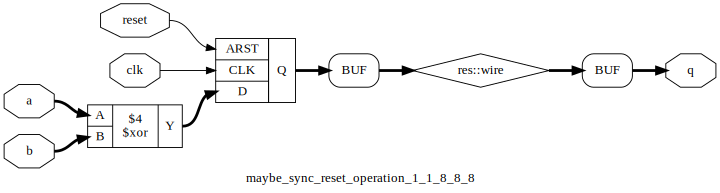

In [9]:
from ys_aux import to_svg
from myhdl.conversion import yshelper

a, b, c = [ Signal(intbv()[8:]) for i in range(3) ]

clk = Signal(bool())

# This reset signal, by default, is asynchronous:
reset = ResetSignal(0, 1, isasync = True)


design = yshelper.Design("test")
inst = maybe_sync_reset_operation(clk, reset, a, b, c)
inst.convert("yosys_module", design, name="test", trace=True)

display(to_svg(design))

You might wonder, where the initial value of `0x55` is left: It's passed as parameter (not visible in the diagram) to the `ADFF` flipflop .
**Small exercise**: Try setting the `isasync` parameter of the ResetSignal to False and rerun the script.

In [10]:
from myhdlpeek import Peeker  # Import the myhdlpeeker module.

Peeker.clear()
Peeker(clk, 'clk')
Peeker(reset, 'reset')
Peeker(a, 'a')
Peeker(b, 'b')
Peeker(c, 'c')

VALUES = [ 0x20, 0x55, 0x00, 0xff ]

def stimulus():
    a.next = 0x54
    b.next = 0x55
    reset.next = True
    yield(delay(1))

    for _ in range(3):
        clk.next = False
        yield(delay(1))
        clk.next = True
        yield(delay(1))
    reset.next = False
    for val in VALUES:
        a.next = val        
        clk.next = False
        yield(delay(1))
        clk.next = True
        yield(delay(1))
    clk.next = False
    yield(delay(1))
    clk.next = True
    yield(delay(1))    
    yield(delay(3))
    reset.next = True

# Instanciate the logic unit:
uut = maybe_sync_reset_operation(clk, reset, a, b, c)

sim = Simulation(uut, stimulus(), *Peeker.instances())
sim.run()
sim.quit()

Peeker.to_wavedrom()

<class 'myhdl.StopSimulation'>: No more events
